# Explanation

The GAN is one of the early forms of generative models that works well empirically. It differs completely from most of the other generative models which use probabilistic approaches to modeling the complexity of images. GANs instead take a game-theoretic approach.

I've chosen to highlight GANs less in this repository (just covering the original GAN paper without some of the developments) since diffusion models appear to be overtaking GANs now for image state-of-the-art image generation.

# Intuition

GANs approach image generation by creating 2 models - a **generator** and a **discriminator** that work against each other, and each interact with each others training objectives.

The generator is meant to produce images of increasing realism to make it difficult for the discriminator to distinguish between synthesized images, and images actually from the training set.

Meanwhile, the discriminator has to learn to distinguish between the generated images and the images from the original training set.

This adversarial training can also present training challenges as the generator and discriminator have to continually increase in quality together. If one becomes significantly better than the other, co-improvement will halt and it will become too easy for one model to win. In practice, this presents many challenges in effective training, and this challenge is one of the reasons why other generative models have been getting a lot of attention recently (since they don't use this challenging adversarial training process).

# My Notes

## 📜 [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661v1)

> We propose a new framework for estimating generative models via an adversarial process, in which we simultaneously train two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

> This framework corresponds to a minimax two-player game.

> Deep generative models have had less of an impact, due to the difficulty of approximating many intractable probabilistic computations that arise in maximum likelihood estimation and related strategies, and due to difficulty of leveraging the benefits of piecewise linear units in the generative context.

### Adversarial Nets

> We train $D$ to maximize the probability of assigning the correct label to both training examples and samples from $G$. We simultaneously train $G$ to minimize $\log(1 − D(G(z)))$

> In other words, $D$ and $G$ play the following two-player minimax game with value function $V(G,D)$

$$
\underset{G}{\textrm{min}} \, \underset{D}{\textrm{max}} \,
V(D,G) = \mathbb{E}_{x \sim p_{\textrm{data}}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_x(z)} [\log(1 - D(G(z))]
$$

> Rather than training G to minimize $\log(1 − D(G(z)))$ we can train $G$ to maximize $\log D(G(z))$. This objective function results in the
> same fixed point of the dynamics of $G$ and $D$ but provides much stronger gradients early in learning.

Allowing the generator to maximize the probability of fooling the discriminator, rather than minimize the probability of getting discovered by the discriminator, provides a better optimization since it’s very easy for the discriminator to vote against the generator early on.

### Experiments

![Screenshot 2024-05-18 at 2.04.41 PM.png](../../images/Screenshot_2024-05-18_at_2.04.41_PM.png)

### Advantages and Disadvantages

> The disadvantages are primarily that there is no explicit representation of $p_g(x)$, and that $D$ must be synchronized well with $G$ during training (in particular, G must not be trained too much without updating D).

> The advantages are that Markov chains are never needed, only back-prop is used to obtain gradients, no inference is needed during learning, and a wide variety of functions can be incorporated into the model.

Generative adversarial models are far more computationally efficient than the previous Markov chain based models.


# Implementation

Below is my implentation of a simple GAN to generate images trained on the MNIST dataset, based on [this simple implementation I found](https://github.com/lyeoni/pytorch-mnist-GAN).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
batch_size = 100
learning_rate = 0.0002
data_dim = 784
hidden_dim = 256
input_dim = 100

In [ ]:
from torchvision import datasets, transforms

# MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim*4, output_dim)
        )

    def forward(self, x):
        return torch.tanh(self.layers(x))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

In [ ]:
generator = Generator(input_dim=input_dim, output_dim=data_dim).to(device)
discriminator = Discriminator(data_dim).to(device)

In [ ]:
bce_loss = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [ ]:
def train_discriminator(x):
    discriminator.zero_grad()

    # train discriminator on real images
    x_real, y_real = x.view(-1, data_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    d_output = discriminator(x_real)
    d_real_loss = bce_loss(d_output, y_real)
    d_real_score = d_output

    # train discriminator on fake images made by the generator
    z = Variable(torch.randn(batch_size, input_dim).to(device))
    x_fake, y_fake = generator(z), Variable(torch.zeros(batch_size, 1).to(device))

    d_output = discriminator(x_fake)
    d_fake_loss = bce_loss(d_output, y_fake)
    d_fake_score = d_output

    # gradient backprop & optimize the discriminator parameters
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()

    return  d_loss.data.item()

In [ ]:
def train_generator(x):
    generator.zero_grad()

    z = Variable(torch.randn(batch_size, input_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    g_output = generator(z)
    d_output = discriminator(g_output)
    g_loss = bce_loss(d_output, y)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [ ]:
for epoch in range(epochs):
    d_losses = []
    g_losses = []
    for batch_idx, (x, _) in enumerate(train_loader):
        d_losses.append(train_discriminator(x))
        g_losses.append(train_generator(x))

    average_d_loss = torch.mean(torch.FloatTensor(d_losses))
    average_g_loss = torch.mean(torch.FloatTensor(g_losses))
    print(f"epoch {epoch + 1}: loss_d: {average_d_loss}, loss_g: {average_g_loss}")


epoch 0: loss_d: 0.4694834351539612, loss_g: 3.4584171772003174
epoch 1: loss_d: 0.3597269058227539, loss_g: 3.9904792308807373
epoch 2: loss_d: 0.4411783218383789, loss_g: 3.6573445796966553
epoch 3: loss_d: 0.45479676127433777, loss_g: 3.369074821472168
epoch 4: loss_d: 0.415654718875885, loss_g: 3.3445539474487305
epoch 5: loss_d: 0.44274765253067017, loss_g: 3.3152101039886475
epoch 6: loss_d: 0.49473851919174194, loss_g: 2.95190167427063
epoch 7: loss_d: 0.5847546458244324, loss_g: 2.637479543685913
epoch 8: loss_d: 0.6040191650390625, loss_g: 2.49985671043396
epoch 9: loss_d: 0.6860063076019287, loss_g: 2.25478458404541
epoch 10: loss_d: 0.7055953145027161, loss_g: 2.197316884994507
epoch 11: loss_d: 0.7307576537132263, loss_g: 2.127225637435913
epoch 12: loss_d: 0.7442054748535156, loss_g: 2.0663933753967285
epoch 13: loss_d: 0.7234012484550476, loss_g: 2.066810369491577
epoch 14: loss_d: 0.7898911833763123, loss_g: 1.9647754430770874
epoch 15: loss_d: 0.8000964522361755, loss_g

With the trained GAN, we can now look at start generating images (conditioned just on random noise) and start looking at the results

In [ ]:
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

def show_image(x, idx, figure=True):
    if figure:
      fig = plt.figure()

    x = x.view(batch_size, 28, 28)
    plt.imshow(x[idx].cpu().numpy())

with torch.no_grad():
    z = Variable(torch.randn(batch_size, input_dim)).to(device)
    generated_images = generator(z)

    save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

Here are some cherry-picked images from the samples that resemble actual numbers nicely.

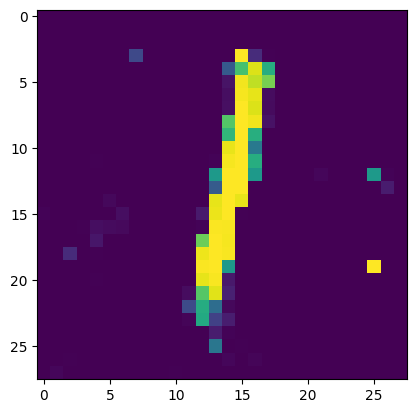

In [ ]:
show_image(generated_images, idx = 1)

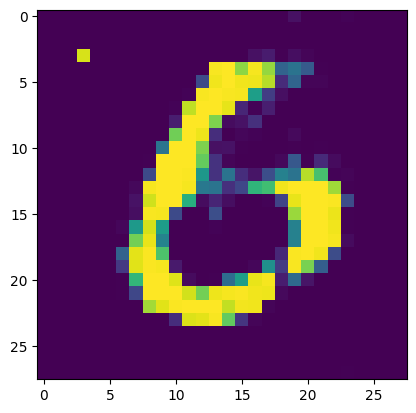

In [ ]:
show_image(generated_images, idx = 3)